* Tensorflow_basic_7

<LSTM & GRU 을 활용한 삼성전자 주가 예측>

via 최효원's Jupyter notebook

----------------------------------------------

SimpleRNN 단점 - 장기 의존성 문제

(입력데이터가 많아질수록 은닉층에서 보관하는 과거 정보가 마지막 layer 까지 충분히 전달되지 못함)

LSTM - layer 사이에 공유되는 셀 상태(cell state) Ct 변수가 추가 공유되면서 기존의 상태 보존, 장기 의존성 문제를 해결할 수 있음

(이전 단계 정보를 memory cell 저장해 다음 단계로 전달)

----------------------------------------------

forget gate(과거 정보를 얼마나 반영할지) , input gate(현재 입력 정보를 얼마나 반영할지), output gate 등으로 구성.

LSTM Example)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = pd.read_csv('samsung.csv')
#데이터 출처 : yahoo finance(2000-01-04 ~ 2021-06-18)
df.head()
#3MA - 3일 이동평균선 #5MA - 5일 이동평균선 #Volume - 거래량 #target 변수 - Adj Close(수정 종가)

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0,4476.348958,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0,4328.948079,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598


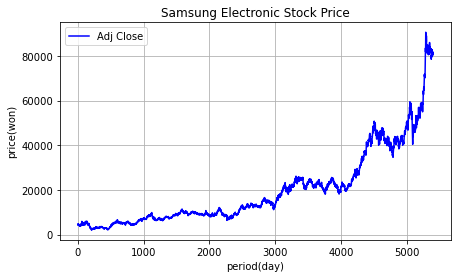

In [2]:
plt.figure(figsize = (7,4))
plt.title('Samsung Electronic Stock Price')
plt.ylabel('price(won)')
plt.xlabel('period(day)')
plt.grid()

plt.plot(df['Adj Close'], label = 'Adj Close', color = 'b')
plt.legend(loc = 'best')
plt.show()

*LSTM 을 활용해 20년 간 주가 데이터를 모델에 학습시키고, 예측 작업을 진행했습니다.

In [3]:
df.describe().T
#Volume(주식 거래량) 의 min 값이 0 -> NaN(결측치) 로 취급

,count,mean,std,min,25%,50%,75%,max
Open,5389.0,2.280189e+04,1.773620e+04,2540.000000,9.880000e+03,1.576000e+04,2.928000e+04,9.030000e+04
High,5389.0,2.304399e+04,1.790683e+04,2760.000000,9.990000e+03,1.594000e+04,2.956000e+04,9.680000e+04
Low,5389.0,2.255929e+04,1.757211e+04,2420.000000,9.800000e+03,1.556000e+04,2.900000e+04,8.950000e+04
Close,5389.0,2.280191e+04,1.773330e+04,2730.000000,9.900000e+03,1.580000e+04,2.928000e+04,9.100000e+04
Adj Close,5389.0,1.992004e+04,1.732264e+04,2117.926025,7.726938e+03,1.280860e+04,2.456656e+04,9.059741e+04
Volume,5389.0,2.207838e+07,1.564053e+07,0.000000,1.185265e+07,1.803935e+07,2.771475e+07,1.642150e+08
3MA,5393.0,1.993422e+04,1.731330e+04,2164.473877,7.726939e+03,1.280281e+04,2.455817e+04,9.003325e+04
5MA,5391.0,1.992559e+04,1.729270e+04,2179.989746,7.709872e+03,1.280931e+04,2.455527e+04,8.956201e+04


In [4]:
df.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
3MA          2
5MA          4
dtype: int64

In [5]:
df.loc[df['Open'].isnull()]
#해당 날짜가 공휴일 또는 국경일이라 거래가 발생하지 않은 것으로 추측됩니다,

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [6]:
#volume = 0 인 데이터를 NaN 으로 변환

df['Volume'] = df['Volume'].replace(0, np.nan)
df.isnull().sum()

Date           0
Open           6
High           6
Low            6
Close          6
Adj Close      6
Volume       122
3MA            2
5MA            4
dtype: int64

In [7]:
#결측치 행 전부 삭제

df = df.dropna()
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [8]:
#Date 변수를 제외한 나머지 변수 - minmax 정규화(0 ~ 1 사이의 값)

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

sc_df = sc.fit_transform(df[df.columns[1:]])
sc_df = pd.DataFrame(sc_df, columns = df.columns[1:])
sc_df

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,0.034868,0.032008,0.036288,0.034440,0.026655,0.285359,0.025192,0.025698
1,0.037375,0.035517,0.038470,0.034440,0.026655,0.363715,0.025634,0.025094
2,0.034982,0.031689,0.036518,0.033873,0.026217,0.177799,0.026163,0.025343
3,0.034868,0.031689,0.036059,0.033760,0.026129,0.250704,0.025987,0.025503
4,0.036235,0.033177,0.037437,0.035120,0.027181,0.300555,0.026163,0.026018
...,...,...,...,...,...,...,...,...
5264,0.891750,0.830923,0.896647,0.881047,0.885878,0.064088,0.895299,0.903144
5265,0.892890,0.834113,0.897795,0.885578,0.890399,0.061199,0.894920,0.900854
5266,0.899727,0.841557,0.903537,0.895774,0.900571,0.091190,0.897955,0.902457
5267,0.895169,0.835177,0.898944,0.885578,0.890399,0.085145,0.899472,0.902228


In [9]:
feature_cols = ['3MA', '5MA', 'Adj Close']
#feature 정의(입력 데이터)
label_cols = ['Adj Close']
#label 정의(정답 데이터)

feature_df = pd.DataFrame(sc_df, columns = feature_cols)
label_df = pd.DataFrame(sc_df, columns = label_cols)

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()
#딥러닝 학습을 위해 넘파이 형태로 변환

In [10]:
#학습 데이터 X, y 생성

def make_seq(feature, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(feature) - window_size):
        
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    
    return np.array(feature_list), np.array(label_list)

In [11]:
window_size = 40

X,y = make_seq(feature_np, label_np, window_size)
print(X.shape, y.shape)

(5229, 40, 3) (5229, 1)


In [12]:
#트레이닝/ 테스트 데이터 분리

split = -200

xtr = X[0:split]
ytr = y[0:split]
xt = X[split:]
yt = y[split:]

print(xtr.shape, ytr.shape)
print(xt.shape, yt.shape)
#트레이닝 데이터: 5029 개, 테스트 데이터: 200 개

(5029, 40, 3) (5029, 1)
(200, 40, 3) (200, 1)


In [16]:
#모델링 및 컴파일

md = Sequential()
md.add(LSTM(128, activation = 'tanh', input_shape = xtr[0].shape))
md.add(Dense(1, activation = 'linear'))

md.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
md.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

md.fit(xtr, ytr, validation_data = (xt, yt), epochs = 100, batch_size = 16,\
      callbacks = [early_stop])

Epoch 1/100
315/315 [==============================] - 11s 29ms/step - loss: 8.1950e-04 - mae: 0.0108 - val_loss: 0.0013 - val_mae: 0.0268
Epoch 2/100
315/315 [==============================] - 11s 36ms/step - loss: 8.3960e-05 - mae: 0.0060 - val_loss: 7.0777e-04 - val_mae: 0.0177
Epoch 3/100
315/315 [==============================] - 10s 31ms/step - loss: 8.1628e-05 - mae: 0.0059 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 4/100
315/315 [==============================] - 10s 32ms/step - loss: 7.0876e-05 - mae: 0.0055 - val_loss: 5.0681e-04 - val_mae: 0.0158
Epoch 5/100
315/315 [==============================] - 11s 35ms/step - loss: 6.7937e-05 - mae: 0.0054 - val_loss: 8.6504e-04 - val_mae: 0.0226
Epoch 6/100
315/315 [==============================] - 12s 37ms/step - loss: 6.8706e-05 - mae: 0.0055 - val_loss: 9.1885e-04 - val_mae: 0.0266
Epoch 7/100
315/315 [==============================] - 11s 34ms/step - loss: 7.1837e-05 - mae: 0.0056 - val_loss: 4.6418e-04 - val_mae: 0.0151
Epoch 8

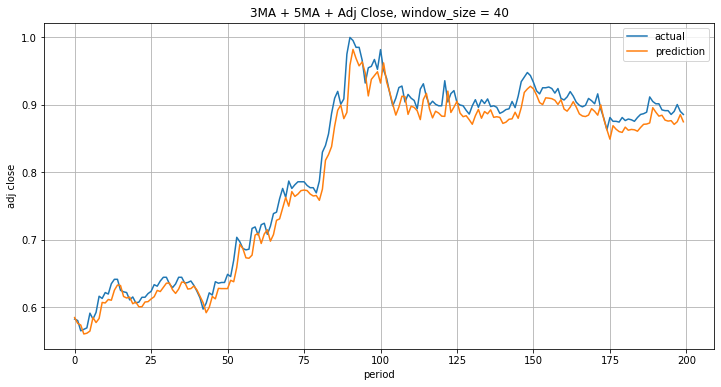

In [21]:
#예측값, 실제값 비교(시각화)

pred = md.predict(xt)

plt.figure(figsize = (12, 6))
plt.title('3MA + 5MA + Adj Close, window_size = 40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(yt, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.grid()
plt.legend(loc = 'best')

plt.show()

*실제값과 예측값을 시각화했을 때, 비슷한 추세와 약간의 오차를 확인할 수 있었습니다.

In [22]:
#MAPE(평균절대값백분율오차)

print(np.sum(abs(yt - pred)/yt) / len(xt))

0.019533388745206017


*최종 모델 MAPE - 약 0.02 로 확인됐습니다.

------------------------------------------------------------------------

* GRU

- LSTM 과 구조 비슷하지만, 더 간단해서 계산상으로 이점이 있음.

- 내부 구조 : Reset gate, Update gate

- LSTM 의 cell state 역할 = GRU 계층의 출력값 H

- 활성화 함수(LSTM : sigmoid 3개, tanh 2개 / GRU : sigmoid 2개, tanh 1개)

*연산량을 상당히 줄일 수 있습니다.

Reset Gate : 과거의 정보를 얼마나 잊을지(기억할지) 결정하는 게이트, sigmoid 함수(0 ~ 1) 사용

Update Gate : 과거와 현재 정보 가운데, 어떤 정보를 더 많이 업데이트 할지 결정하는 게이트, sigmoid 함수(0 ~ 1) 사용

--> LSTM 의 input gate 와 forget gate 를 합쳐놓은 개념이라 할 수 있습니다.

Candidate(데이터 선정) - 다음 시점으로 전달해줄 데이터를 만들기 위해, 현재 시점에서 데이터를 선정하는 단계, tanh 함수 사용

GRU Example)

In [26]:
#GRU 모델링 및 컴파일

from tensorflow.keras.layers import GRU

md2 = Sequential()

md2.add(GRU(256, activation = 'tanh', input_shape = xtr[0].shape))
#GRU layer 에 tanh 활성화함수로 가지는 노드 수 = 256, input_shape = (40, 3)

md2.add(Dense(1, activation = 'linear'))
md2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 256)               200448    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 200,705
Trainable params: 200,705
Non-trainable params: 0
_________________________________________________________________


In [27]:
md2.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
md2.fit(xtr, ytr, validation_data = (xt, yt), epochs = 100, batch_size = 16, callbacks = [early_stop])

Epoch 1/100
315/315 [==============================] - 21s 60ms/step - loss: 7.7760e-04 - mae: 0.0101 - val_loss: 0.0012 - val_mae: 0.0289
Epoch 2/100
315/315 [==============================] - 19s 61ms/step - loss: 5.3818e-05 - mae: 0.0048 - val_loss: 4.7468e-04 - val_mae: 0.0155
Epoch 3/100
315/315 [==============================] - 19s 62ms/step - loss: 5.0901e-05 - mae: 0.0048 - val_loss: 3.0715e-04 - val_mae: 0.0127
Epoch 4/100
315/315 [==============================] - 16s 49ms/step - loss: 4.3858e-05 - mae: 0.0044 - val_loss: 3.3798e-04 - val_mae: 0.0148
Epoch 5/100
315/315 [==============================] - 15s 49ms/step - loss: 4.5447e-05 - mae: 0.0046 - val_loss: 3.8626e-04 - val_mae: 0.0144
Epoch 6/100
315/315 [==============================] - 16s 51ms/step - loss: 4.1125e-05 - mae: 0.0044 - val_loss: 2.3734e-04 - val_mae: 0.0113
Epoch 7/100
315/315 [==============================] - 16s 49ms/step - loss: 3.9796e-05 - mae: 0.0044 - val_loss: 2.2176e-04 - val_mae: 0.0108
Epo

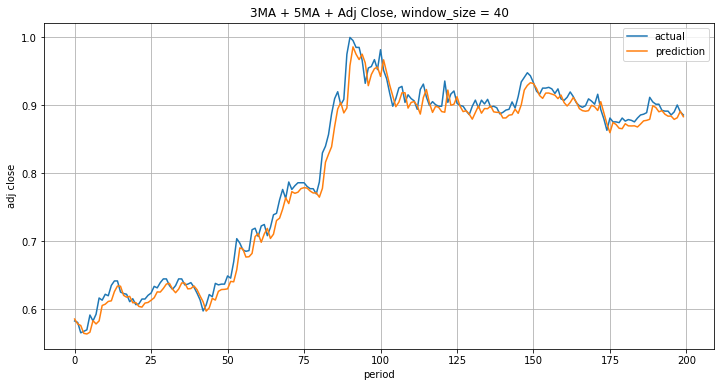

In [28]:
#예측값, 실제값 비교(시각화)

pred2 = md2.predict(xt)

plt.figure(figsize = (12, 6))
plt.title('3MA + 5MA + Adj Close, window_size = 40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(yt, label = 'actual')
plt.plot(pred2, label = 'prediction')
plt.grid()
plt.legend(loc = 'best')

plt.show()

*GRU 예측값도 LSTM 과 마찬가지로 같은 방향과, 크지 않은 오차를 확인할 수 있었습니다.

*GRU, LSTM 모두 주식 데이터를 분석하고 예측하기 적합한 구조이며, 분석하고자 하는 특정 문제/ 도메인에 따라 더 나은 layer 선정 필요.